## Generalize discovered solutions

In the previous notebook we have solutions for realizing a directional coupler with two input ports. In this notebook, we demonstrate how our graph-based solutions can be generalized to realize an arbitrary number of input ports.

For further details, checkout our [GitHub](https://github.com/jlandgr/autoscatter) and [arxiv:2404.14887](https://arxiv.org/abs/2404.14887).

In [8]:
# In case you are using Google Colab, this cell will install you AutoScatter
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    !pip install git+https://github.com/jlandgr/autoscatter.git

In [9]:
import sympy as sp
import numpy as np
import jax
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import autoscatter.architecture_optimizer as arch_opt
import autoscatter.constraints as msc
import autoscatter.symbolic as sym
np.set_printoptions(linewidth=200)
from autoscatter.architecture import adjacency_to_triu_matrix, triu_to_adjacency_matrix

Exemplarily, we analyse and generalise our discovered graph (I) in Fig. 4(b). Mode 1 and 2 are the input modes, mode 3 is the output, mode 4 and 5 are auxiliary modes.

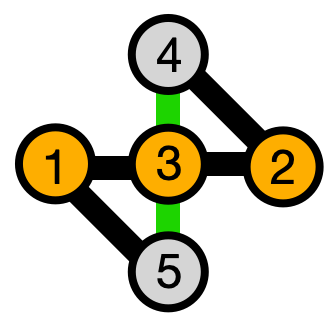

The graph above can be described by its adjacency matrix:

$\begin{pmatrix}
0&0&1&0&1\\0&0&1&1&0\\1&1&0&2&2\\0&1&2&0&0\\1&0&2&0&0
\end{pmatrix}
$

0 corresponds to no coupling, 1 to a real coupling, 2 to a complex coupling.


All of our graphs are undirected and, therefore, their corresponding adjacency matrices are symmetric. To avoid reduncandcy our code works with the upper triangual matrix of the adjacency matrix, written down as a list.
The graph above corresponds to the list [0,0,1,0,1,0,1,1,0,0,2,2,0,0,0]. You can convert adjacency matrices to upper triangular lists and vice versa using the functions adjacency_to_triu_matrix and triu_to_adjacency_matrix.

In [10]:
graph_to_test = np.array([0,0,1,0,1,0,1,1,0,0,2,2,0,0,0])

In [11]:
# initialize the optimizer
t = sp.Symbol('t', real=True) # transmission rate
S_target = sp.Matrix([[0,0,0],[0,0,0],[t,t,0]])
optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=2,
)

fully connected graph is a valid graph


Let us perform the continuous optimisation just for the graph above. The method repeated_optimization will try repeatitively try to find a solution for the specified graph. If not successful within a certain number of tries (by default 10), the method will return that the optimisation failed

In [12]:
success, infos, _ = optimizer.repeated_optimization(triu_matrix=graph_to_test, **optimizer.kwargs_optimization, **optimizer.solver_options)
print('optimisation was successful:', success)

optimisation was successful: True


The list infos contains information about all tries to find a solution. The last element corresponds to the solution where the loss was successfully minimized to zero.
Most importantly infos contains the found parameters, but also information about the optimisation, like the loss history

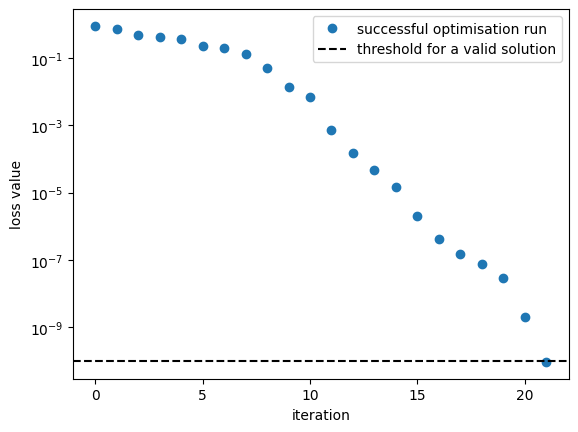

In [13]:
plt.semilogy(infos[-1]['loss_history'], marker='o', ls='None', label='successful optimisation run')
plt.axhline(optimizer.kwargs_optimization['max_violation_success'], color='black', ls='dashed', label='threshold for a valid solution')
plt.xlabel('iteration')
plt.ylabel('loss value')
plt.legend()

Show the solution for the found dimensionless parameter values.
Please note the indexing convention: Mode 0 and Mode 1 are the input modes, mode 2 the output mode, mode 3 and 4 are auxiliary modes

In [14]:
infos[-1]['solution_dict']

{'|g_{0,2}|': -0.35354709944116103,
 '|g_{0,4}|': 0.499996233390668,
 '|g_{1,2}|': 0.3535514187899701,
 '|g_{1,3}|': -0.4999971240310108,
 '|g_{2,3}|': -0.3535515522393245,
 '|g_{2,4}|': -0.35354975593460125,
 '\\mathrm{arg}(g_{2,3})': 1.5707935049545576,
 '\\mathrm{arg}(g_{2,4})': 1.570796129935481,
 'gamma^out_0': 1.937320445053093,
 'gamma^out_1': -1.2042839307229878,
 'gamma^out_2': -0.3665201427750805,
 't': -0.707104152412417}

Or the more compressed information required for the following analysis: The cooperativities and the value for the transmission rate. It is easy to see, that the transmission rate equals 1/sqrt(2) and that the cooperativites are either 1 or 1/2.

In [15]:
infos[-1]['parameters_for_analysis']

{'C_{0,2}': 0.49998220609303284,
 'C_{0,4}': 0.9999849336194214,
 'C_{1,2}': 0.4999944229136033,
 'C_{1,3}': 0.999988496157128,
 'C_{2,3}': 0.4999948003633432,
 'C_{2,4}': 0.49998971968566447,
 't': -0.707104152412417}

Let's generalise our findings. Inspecting our graph, we note that it can be viewed as the combination of two isolator graphs. This inspires a general ansatz for an $N_\mathrm{in}$-port coupler: a graph that comprises an isolator building block for each input port

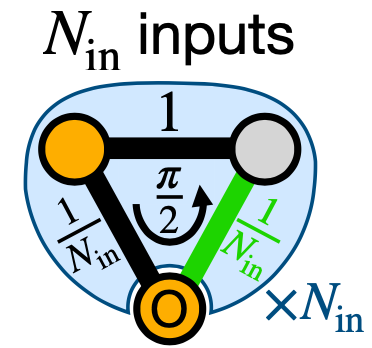

target scattering matrix for 6 inputs:


<IPython.core.display.Math object>

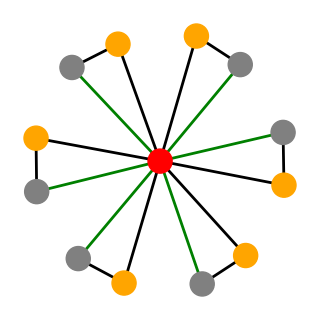

In [16]:
def generate_target_scattering_matrix(num_input_ports):
    '''
    generates the target scattering matrix for a directional coupler with num_input_ports inputs and 1 output port
    it will keep the convention, that mode 0 up to mode num_input_ports-1 will be the input ports, mode num_input_ports will be the output port
    '''
    t = sp.Symbol('t', real=True)
    S_target = sp.zeros(num_input_ports,num_input_ports+1)
    S_target = S_target.row_insert(num_input_ports, sp.Matrix([[t]*num_input_ports+[0]]))
    return S_target

def generate_graph_list(num_input_ports):
    '''
    generates the target scattering matrix for a directional coupler with num_input_ports inputs and 1 output port
    it will keep the convention, that mode 0 up to mode num_input_ports-1 will be the input ports, mode num_input_ports will be the output port, the remaining modes are the auxiliary modes
    '''
    num_modes = 2*num_input_ports + 1
    adjacency_matrix = np.zeros([num_modes, num_modes], dtype='int8')
    output_idx = num_input_ports
    for input_idx in range(num_input_ports):
        auxiliary_idx = num_input_ports + input_idx + 1
        adjacency_matrix[input_idx, auxiliary_idx] = adjacency_matrix[auxiliary_idx, input_idx] = 1 # coupling between input and auxiliary mode is a real coupling
        adjacency_matrix[input_idx, output_idx] = adjacency_matrix[output_idx, input_idx] = 1 # coupling between input and output mode is a real coupling
        adjacency_matrix[output_idx, auxiliary_idx] = adjacency_matrix[auxiliary_idx, output_idx] = 2 # coupling between output and auxiliary mode is a complex coupling
    
    return adjacency_to_triu_matrix(adjacency_matrix)

num_input_ports = 6
S_target = generate_target_scattering_matrix(num_input_ports)
graph_to_test = generate_graph_list(num_input_ports)
node_colors = ['orange']*num_input_ports + ['red'] + ['gray']*num_input_ports
print('target scattering matrix for %i inputs:'%num_input_ports)
sym.render(S_target)
plt.figure(figsize=(3,3))
msc.plot_graph(triu_matrix=graph_to_test, node_colors=node_colors)

In [17]:
optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=num_input_ports,
    make_initial_test=False,
    kwargs_optimization={'num_tests': 100}, # increase number of tests to 20 (default: 10)
    solver_options={'maxiter': 5000} # increase the maximum number of iterations (default: 200)
)

success, infos, _ = optimizer.repeated_optimization(triu_matrix=graph_to_test, **optimizer.kwargs_optimization, **optimizer.solver_options)
print('optimisation was successful:', success)

optimisation was successful: True


In [18]:
infos[-1]['parameters_for_analysis']

{'C_{0,6}': 0.16666705803043197,
 'C_{0,7}': 1.0000008593694656,
 'C_{1,6}': 0.16666649419375557,
 'C_{1,8}': 1.000001641593431,
 'C_{2,6}': 0.16666690281120927,
 'C_{2,9}': 0.9999982756627729,
 'C_{3,6}': 0.1666658563408491,
 'C_{3,10}': 0.9999967698088432,
 'C_{4,6}': 0.1666646931611975,
 'C_{4,11}': 0.9999951014216786,
 'C_{5,6}': 0.16666844883836138,
 'C_{5,12}': 1.0000017095964717,
 'C_{6,7}': 0.16666791573574047,
 'C_{6,8}': 0.16666661405009478,
 'C_{6,9}': 0.16666623437507727,
 'C_{6,10}': 0.16666503896859908,
 'C_{6,11}': 0.16666663732601214,
 'C_{6,12}': 0.16666786278877338,
 't': -0.408247439048948}

Let's analyse the parameters systematically. The following cell will find the continuous parameters for couplers of various number of inputs, all designed according to the rule described above

In [19]:
num_input_ports_variation = [2,3,4,5,6,7,8]
list_transmission_rates = [] # list of transmission rates
list_C_in_out = [] # list of cooperativities between input and output mode
list_C_in_aux = [] # list of cooperativities between input and corresponding auxiliary mode
list_C_out_aux = [] # list of cooperativities between output auxiliary mode

for num_input_ports in num_input_ports_variation:
    S_target = generate_target_scattering_matrix(num_input_ports)
    graph_to_test = generate_graph_list(num_input_ports)

    optimizer = arch_opt.Architecture_Optimizer(
        S_target=S_target,
        num_auxiliary_modes=num_input_ports,
        make_initial_test=False, # skip the test of the fully connected graph to save some time
        kwargs_optimization={'num_tests': 30}, # increase number of tests to 20 (default: 10)
        solver_options={'maxiter': 2000} # increase the maximum number of iterations (default: 200)
    )

    success, infos, _ = optimizer.repeated_optimization(triu_matrix=graph_to_test, **optimizer.kwargs_optimization)
    print(num_input_ports, 'success:', success)
    parameters_for_analysis = infos[-1]['parameters_for_analysis']
    list_transmission_rates.append(parameters_for_analysis['t'])
    input_idx = 0
    output_idx = num_input_ports
    auxiliary_idx = num_input_ports + 1
    list_C_in_out.append(parameters_for_analysis['C_{%i,%i}'%(input_idx,output_idx)])
    list_C_in_aux.append(parameters_for_analysis['C_{%i,%i}'%(input_idx,auxiliary_idx)])
    list_C_out_aux.append(parameters_for_analysis['C_{%i,%i}'%(output_idx,auxiliary_idx)])

2 success: True
3 success: True
4 success: True
5 success: True
6 success: True
7 success: True
8 success: True


Now we plot the extracted cooperativites and transmission rates in a log-log plot. From the slopes one can read of easily, that the transmission rate $t$ equals $1/\sqrt N_\mathrm{in}$, the cooperativity $C_\mathrm{input,auxiliary}$ equals $1$ and $C_\mathrm{input,output}$ and $C_\mathrm{output,auxiliary}$ equal $1/N_\mathrm{in}$.

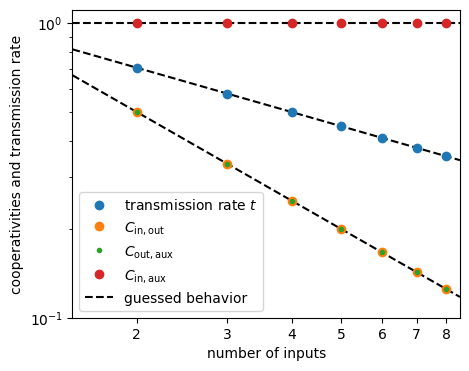

In [20]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(num_input_ports_variation, np.abs(list_transmission_rates), ls='None', marker='o', label='transmission rate $t$')
ax.plot(num_input_ports_variation, list_C_in_out, ls='None', marker='o', label='$C_\mathrm{in,out}$')
ax.plot(num_input_ports_variation, list_C_out_aux, ls='None', marker='o', label='$C_\mathrm{out,aux}$', markersize=3)
ax.plot(num_input_ports_variation, list_C_in_aux, ls='None', marker='o', label='$C_\mathrm{in,aux}$')

# plot dependencies for the parameter values
xs = np.linspace(num_input_ports_variation[0]-.5, num_input_ports_variation[-1]+.5)
ax.axhline(1., label='guessed behavior', ls='dashed', color='black', zorder=-100)
ax.loglog(xs, 1/np.sqrt(xs), ls='dashed', color='black', zorder=-100)
ax.loglog(xs, 1/xs, ls='dashed', color='black', zorder=-100)
ax.set_xlabel('number of inputs')
ax.set_ylabel('cooperativities and transmission rate')
ax.set_xlim(xs[0], xs[-1])
ax.set_ylim(0.1, None)
ax.set_xticks(num_input_ports_variation)
formatter = ScalarFormatter()
formatter.set_scientific(False)  # Disable scientific notation
ax.xaxis.set_major_formatter(formatter)
ax.legend(bbox_to_anchor=(0,0,1,0.9))

In the following we predict the scattering matrix given these estimated parameters dependencies.

In [21]:
def create_solution_dict_from_estimation(num_input_ports):
    '''
    generates a dictionary containing the before described expectation for the coupling and transmission rate. Also the phases are set, such that every triangle loop encloses a flux of pi/2
    '''

    C_in_aux = 1
    C_in_out = 1/num_input_ports
    C_out_aux = 1/num_input_ports
    phase_in_out_aux_in = np.pi/2
    num_modes = 2*num_input_ports + 1

    # initialize a dictionary, where all coupling rates and phases are set to zero
    test_dict = {}
    test_dict.update({'Delta%i'%idx: 0. for idx in range(num_modes)})
    test_dict.update({'|g_{%i,%i}|'%(idx1,idx2): 0. for idx1 in range(num_modes) for idx2 in range(idx1+1,num_modes)})
    test_dict.update({'\mathrm{arg}(g_{%i,%i})'%(idx1,idx2): 0. for idx1 in range(num_modes) for idx2 in range(idx1+1,num_modes)})

    # set the parameter values to the estimated ones
    output_idx = num_input_ports
    for input_idx in range(num_input_ports):
        auxiliary_idx = output_idx + input_idx + 1
        test_dict['|g_{%i,%i}|'%(input_idx,output_idx)] = np.sqrt(C_in_out/4)
        test_dict['|g_{%i,%i}|'%(input_idx,auxiliary_idx)] = np.sqrt(C_in_aux/4)
        test_dict['|g_{%i,%i}|'%(output_idx,auxiliary_idx)] = np.sqrt(C_out_aux/4)
        test_dict['\mathrm{arg}(g_{%i,%i})'%(output_idx,auxiliary_idx)] = phase_in_out_aux_in

    # set the transmission rate
    test_dict['t'] = 1/np.sqrt(num_input_ports)

    # set gauge phases to zero (are anyway to used for the following calculation)
    for idx in range(num_modes):
        test_dict['gamma^out_%i'%idx] = 0.

    return test_dict

num_input_ports = 10
S_target = generate_target_scattering_matrix(num_input_ports)
optimizer = arch_opt.Architecture_Optimizer(
    S_target=S_target,
    num_auxiliary_modes=num_input_ports,
    make_initial_test=False, # skip the test of the fully connected graph to save some time
)
# generate a dictionary containing our guessed parameters
guessed_solution = create_solution_dict_from_estimation(num_input_ports)
# calculate full scattering matrix from guessed solution, this matrix also contains the scattering from and to the auxiliary modes
full_scattering_matrix = optimizer.calc_scattering_matrix_from_parameter_dictionary(guessed_solution)
# extract the scattering between the port modes
scattering_between_ports = full_scattering_matrix[:num_input_ports+1,:num_input_ports+1]
np.round(scattering_between_ports, 2)

Array([[ 0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.+0.j  ],
       [ 0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.+0.j  ],
       [ 0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.+0.j  ],
       [ 0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.+0.j  ],
       [ 0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.+0.j  ],
       [ 0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.+0.j  ],
       [ 0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  , -0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.+0.j  ],
       [ 0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  ,  0.-0.j  , -0.-0

As intended, all inputs are scattered with the same amplitude towards the output, there is no scattering between the inputs, and no scattering from the output towards any of the inputs